In [65]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [66]:
df=pd.read_csv('product a.csv', parse_dates=['Month-Year'])

In [67]:
sales_a= df.drop(['Product Name','Product Category'],axis=1)

In [68]:
sales_a.shape

(60, 2)

In [69]:
sales_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month-Year  60 non-null     datetime64[ns]
 1   Sales       60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


In [70]:
sales_a['Sales'].sum()

3213992

In [71]:
sales_a = sales_a.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_a.head(5)

,ds,y
0,2019-01-01,54555
1,2019-02-01,54293
2,2019-03-01,58798
3,2019-04-01,53229
4,2019-05-01,50558


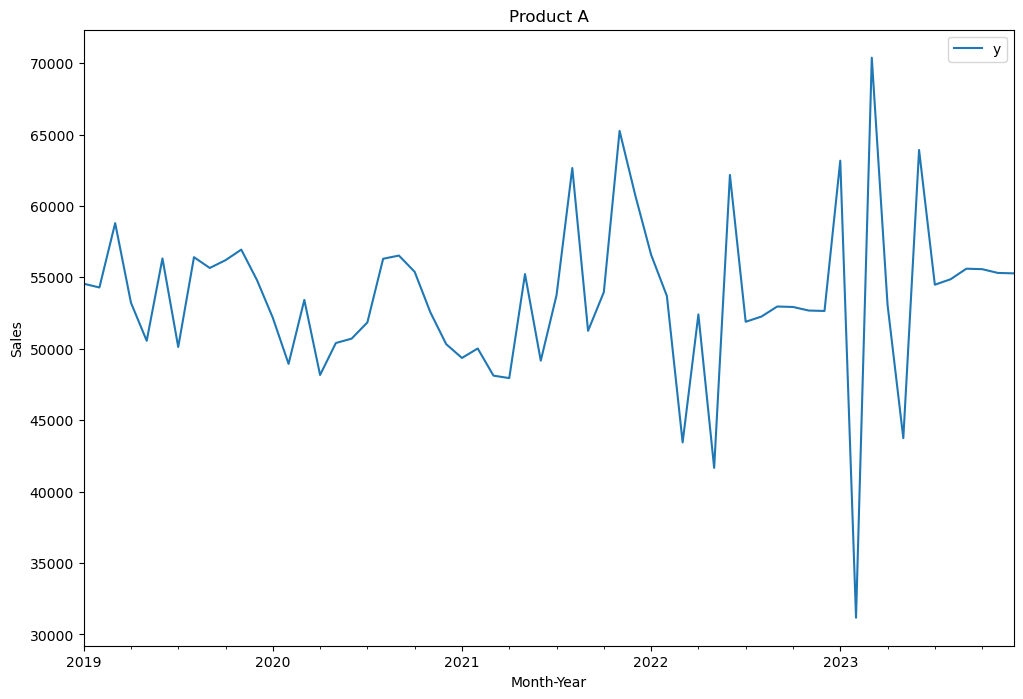

In [72]:
ax = sales_a.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product A')
plt.show()

In [73]:
train= sales_a[:57]
test=sales_a[57:]

# Hyperparameter Tuning

In [74]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

16:07:38 - cmdstanpy - INFO - Chain [1] start processing
16:07:38 - cmdstanpy - INFO - Chain [1] done processing
16:07:44 - cmdstanpy - INFO - Chain [1] start processing
16:07:44 - cmdstanpy - INFO - Chain [1] done processing
16:07:50 - cmdstanpy - INFO - Chain [1] start processing
16:07:50 - cmdstanpy - INFO - Chain [1] done processing
16:07:54 - cmdstanpy - INFO - Chain [1] start processing
16:07:54 - cmdstanpy - INFO - Chain [1] done processing
16:07:58 - cmdstanpy - INFO - Chain [1] start processing
16:07:58 - cmdstanpy - INFO - Chain [1] done processing
16:08:02 - cmdstanpy - INFO - Chain [1] start processing
16:08:04 - cmdstanpy - INFO - Chain [1] done processing
16:08:08 - cmdstanpy - INFO - Chain [1] start processing
16:08:08 - cmdstanpy - INFO - Chain [1] done processing
16:08:12 - cmdstanpy - INFO - Chain [1] start processing
16:08:12 - cmdstanpy - INFO - Chain [1] done processing
16:08:16 - cmdstanpy - INFO - Chain [1] start processing
16:08:17 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0    8929.858393  
1    8892.172639  
2    9039.294946  
3    9070.056348  
4    8989.442689  
..       

In [75]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
7,0.001,3.00,multiplicative,8844.863272
12,0.010,0.01,additive,8881.718944
13,0.010,0.01,multiplicative,8885.536523
1,0.001,0.01,multiplicative,8892.172639
11,0.001,10.00,multiplicative,8899.768025
...,...,...,...,...
60,0.500,0.01,additive,10358.519760
70,0.500,10.00,additive,10364.349428
66,0.500,3.00,additive,10373.436745
69,0.500,5.00,multiplicative,10374.343253


In [76]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 3.0, 'seasonality_mode': 'multiplicative'}


In [77]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=3.0, seasonality_mode = 'multiplicative',
                interval_width=0.95)

In [78]:
model.fit(train)

16:13:12 - cmdstanpy - INFO - Chain [1] start processing
16:13:12 - cmdstanpy - INFO - Chain [1] done processing


In [79]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 3 months in 2023

In [80]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [81]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [82]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
57,2023-10-01,55102.296427,46179.471814,64098.370753
58,2023-11-01,57184.446380,48096.351320,66071.890403
59,2023-12-01,55011.390488,45985.154465,63904.006709


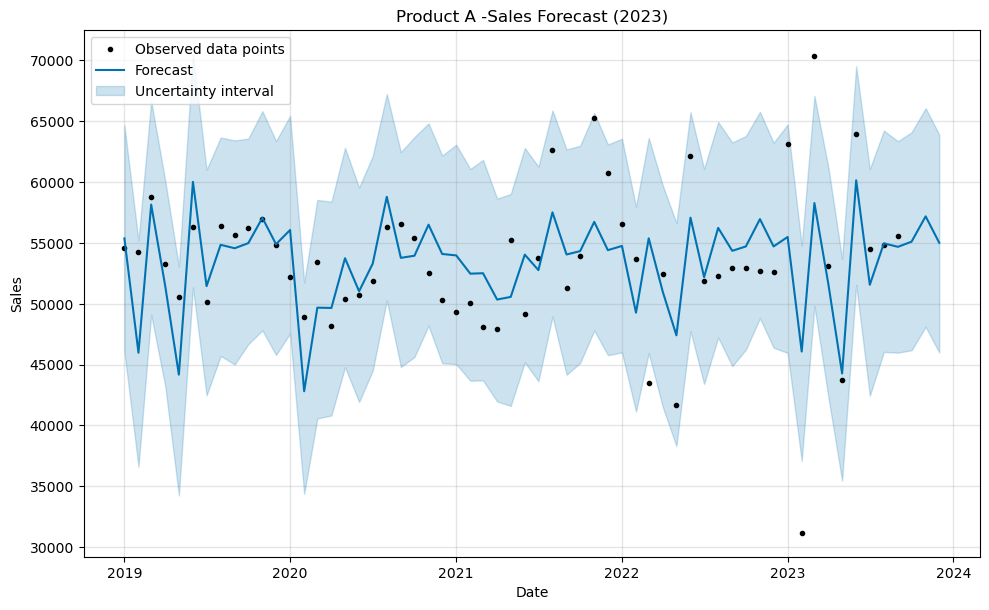

In [83]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product A -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

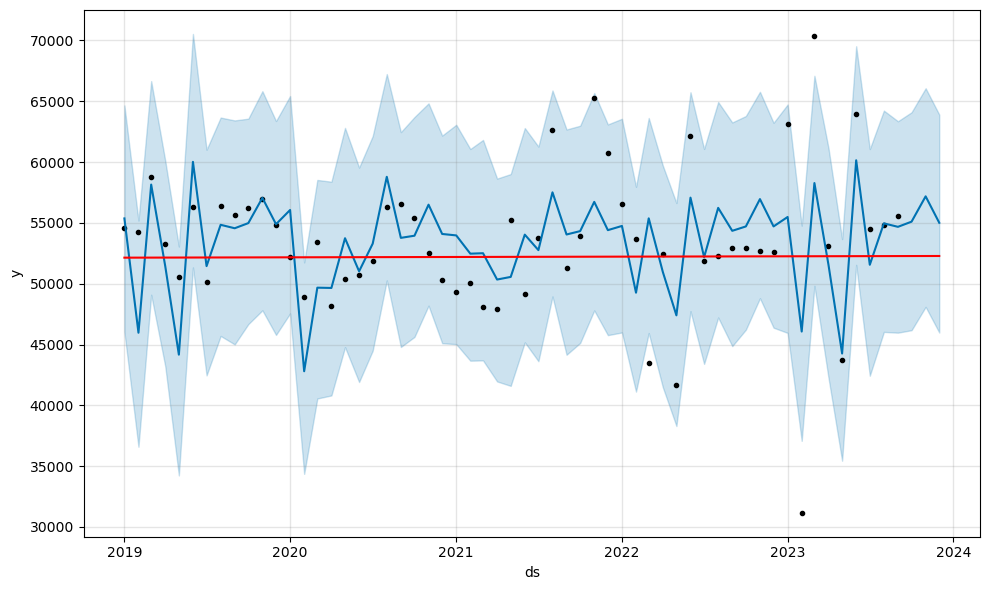

In [84]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

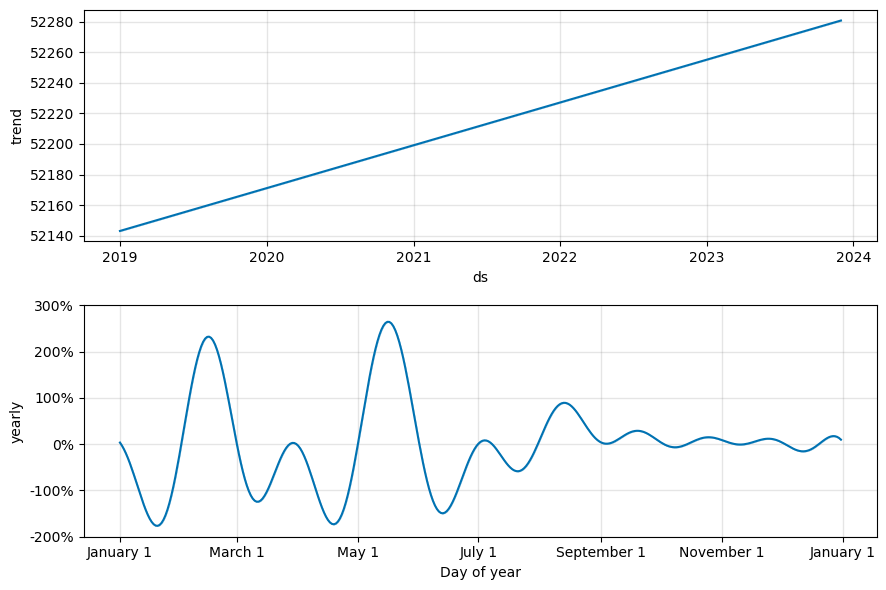

In [85]:
fig2 = model.plot_components(forecast)

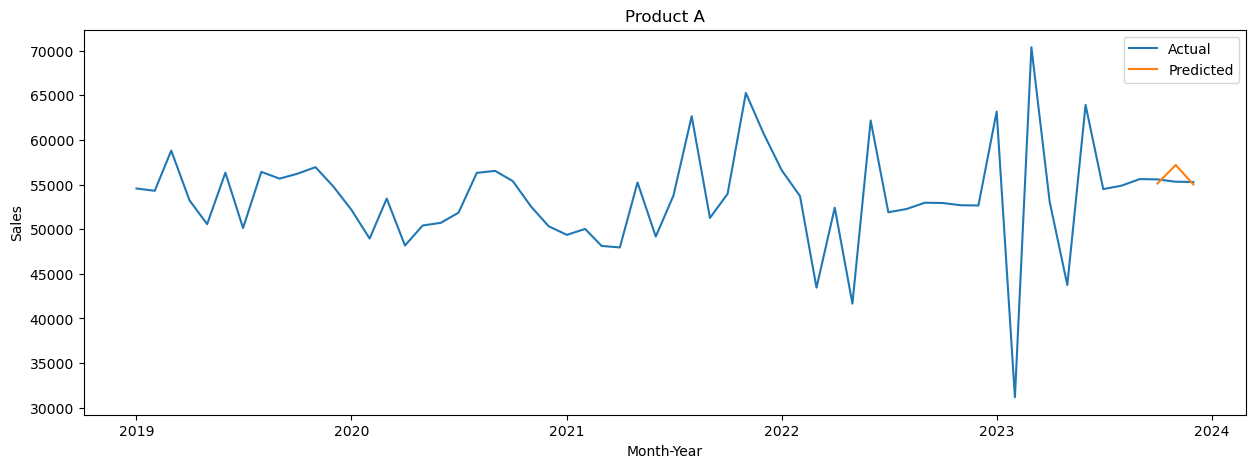

In [86]:
# Reset index of sales_b DataFrame
sales_a_reset_index = sales_a.reset_index()

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(sales_a_reset_index['ds'], sales_a_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product A')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [87]:
#model evaluation

In [88]:
pred=forecasted_df['yhat']
test_df=test['y']

In [89]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 871.920
MAPE - FB PROPHET: 0.016
MSE - FB PROPHET: 1268646.432
RMSE - FB PROPHET: 1126.342


In [90]:
# train data: 0 to 47 --> Jan-2019 to Dec-2022
# test data: 48: 59 --> Jan 2023 to Dec-2023

#sales_b['y'].plot(figsize=(12,8))
#forecast_df['yhat'].plot()
#plt.title('Product B')
#plt.xlabel('Month')
#plt.ylabel('Sales')
#plt.legend(labels=['Actual', 'Predicted'])
#plt.show()

In [92]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days', parallel="processes")

In [93]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,2.716989e+06,1648.329171,1495.694721,0.029164,0.033065,0.029455,0.75
1,52 days,2.007729e+07,4480.769068,3197.845267,0.058820,0.037139,0.062163,0.75
2,56 days,6.293214e+07,7932.978100,6377.659329,0.107245,0.098742,0.116179,0.50
3,57 days,8.314325e+07,9118.292316,8126.668259,0.152035,0.177350,0.155151,0.25
4,61 days,8.884078e+07,9425.538469,8980.504577,0.168281,0.177350,0.170419,0.25
5,83 days,7.088542e+07,8419.348240,7030.186470,0.133358,0.148238,0.132311,0.50
6,86 days,5.540190e+07,7443.244981,6373.230303,0.126282,0.134086,0.123704,0.50
7,88 days,5.559261e+07,7456.045259,6383.487762,0.108080,0.122806,0.114113,0.50
8,91 days,5.029804e+07,7092.110763,5638.736907,0.093947,0.094541,0.100885,0.50
9,113 days,6.074559e+07,7793.945805,7088.749538,0.120618,0.135416,0.129478,0.25


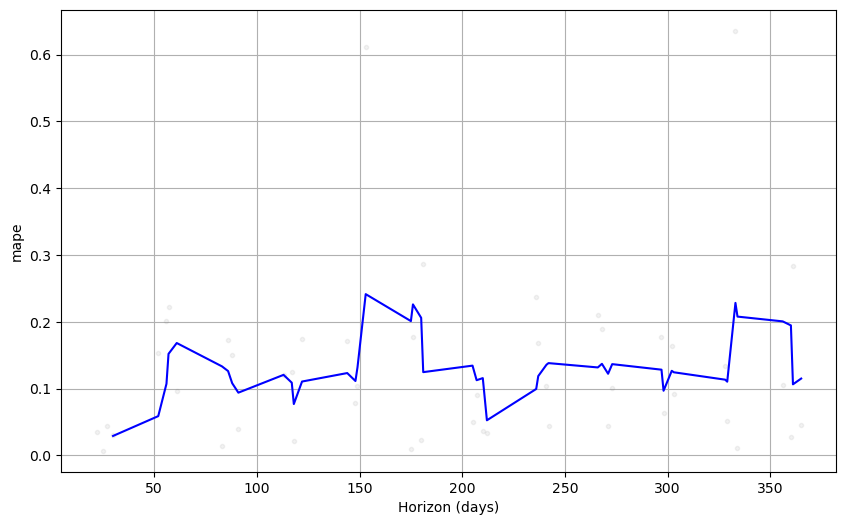

In [94]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [95]:
test_df

57    55575
58    55311
59    55281
Name: y, dtype: int64

In [96]:
pred

57    55102.296427
58    57184.446380
59    55011.390488
Name: yhat, dtype: float64

# FORECASTING

In [97]:
model_forecast = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=3.0, seasonality_mode = 'multiplicative',
                interval_width=0.95)

In [98]:
model_forecast.fit(sales_a)

16:14:17 - cmdstanpy - INFO - Chain [1] start processing
16:14:17 - cmdstanpy - INFO - Chain [1] done processing


In [99]:
# Create a DataFrame for future dates 
future_dates_f = model_forecast.make_future_dataframe(periods=3, freq='MS')  # 3 months in 2024

In [100]:
# Make predictions for the future
forecast_f = model_forecast.predict(future_dates_f)

In [101]:
forecasted_f_df=forecast_f[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [102]:
forecasted_f_df

,ds,yhat,yhat_lower,yhat_upper
60,2024-01-01,56231.012757,47158.686837,65183.425711
61,2024-02-01,43058.072143,34142.339789,51558.455178
62,2024-03-01,49783.553494,41186.151812,58801.350088


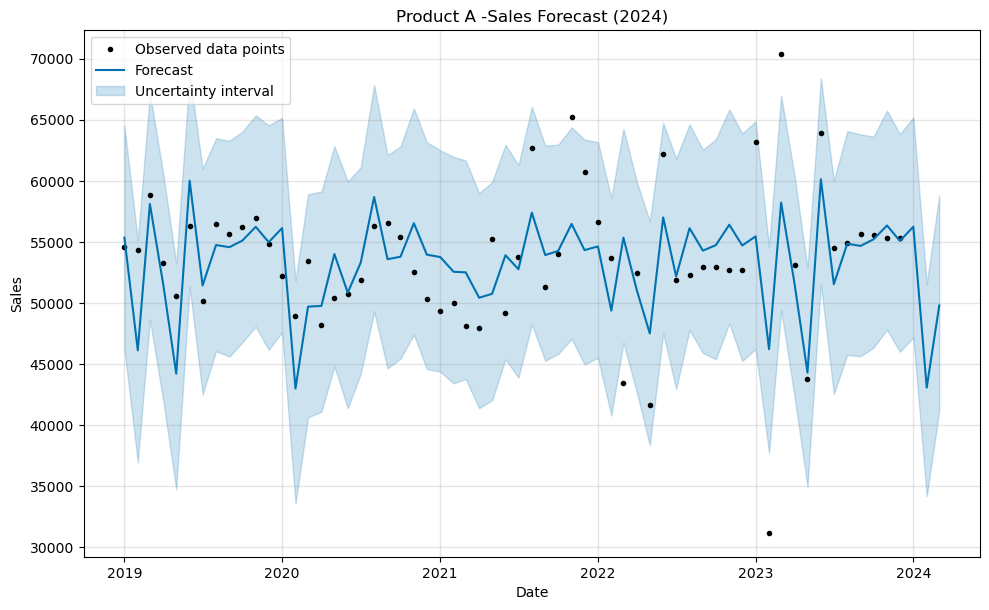

In [103]:
fig = model_forecast.plot(forecast_f, include_legend=True, uncertainty=True)
plt.title('Product A -Sales Forecast (2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [104]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model_forecast,forecast_f)

In [105]:
plot_components_plotly(model_forecast, forecast_f)
